In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from tqdm import tqdm
from utils.mdp_description import MDPDescription
from utils.new_mdp_description import NewMDPDescription, BoundType
from scipy.special import rel_entr
import pickle
from scipy.stats import bootstrap
from matplotlib.transforms import Affine2D
from scipy.stats import bootstrap
from scipy.stats import t
from matplotlib.ticker import StrMethodFormatter, NullFormatter,LogFormatterSciNotation
import matplotlib.style as style
from envs.riverswim import RiverSwim
from envs.forked_riverswim import ForkedRiverSwim
from envs.random_mdp import RandomMDP
from utils.simplified_new_mdp_description import SimplifiedNewMDPDescription
import lzma
np.random.seed(2)
colors = ['magenta','black', 'darkorange', 'blue', 'red']

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

def compute_ce_median(values, c=0.95):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=c).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return np.median(values, axis=0), res[:, 0], res[:, 1]

def computeMK(mdp,k):
    P = mdp.P.reshape(mdp.dim_state * mdp.dim_action, -1)
    temp = (mdp.V_greedy[:, np.newaxis, np.newaxis] - mdp.avg_V_greedy[np.newaxis, ...]) ** (2*k)
    Mk = (P * temp.reshape(mdp.dim_state, mdp.dim_state * mdp.dim_action).T).sum(-1).reshape(mdp.dim_state, mdp.dim_action)
    return Mk

import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

discount_factor = 0.99

In [12]:
Nvalues = [5, 10, 25, 50, 100]
kvalues = np.arange(1, 16, dtype=np.float32)
N_SIMS = 30

U_original_bound = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t0 = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t1 = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_simplified = np.zeros((N_SIMS, len(Nvalues), len(kvalues)))
U_minimax = np.zeros((N_SIMS, len(Nvalues)))

U_new_bound_t0_original_omega = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t1_original_omega = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t0_simplified_omega = np.zeros((N_SIMS, len(Nvalues), len(kvalues)))
U_new_bound_t1_simplified_omega = np.zeros((N_SIMS, len(Nvalues), len(kvalues)))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros((N_SIMS, len(Nvalues)))
TV_policy_new_bound_t1_vs_original_policy = np.zeros((N_SIMS, len(Nvalues)))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros((N_SIMS, len(Nvalues), len(kvalues)))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros((N_SIMS, len(Nvalues), len(kvalues)))



for j in tqdm(range(N_SIMS)):
    _policies_original_bound = []
    _policies_new_bound_t0 = []
    _policies_new_bound_t1 = []
    _policies_simplified_bound = []
    for id_N, N in enumerate(Nvalues):
        env = RandomMDP(num_states=N)
            
        mdp = MDPDescription(env.transitions, env.rewards, discount_factor)
        new_mdp = NewMDPDescription(env.transitions, env.rewards, discount_factor)
        simplified_mdp = [SimplifiedNewMDPDescription(env.transitions, env.rewards, discount_factor, k) for k in kvalues]
        
        
        # Classical upper bound
        U_generative_policy, U_generative_value = mdp.compute_allocation()
        U_original_bound[j,id_N] = U_generative_value
        _policies_original_bound.append(np.array(U_generative_policy))

        U_minimax[j,id_N] = N*3 / ((1-discount_factor)**3 * mdp.delta_sq_min)

        # U0
        p,v = new_mdp.compute_allocation(type=BoundType.BOUND_1)
        U_new_bound_t0[j,id_N] = v
        _policies_new_bound_t0.append(np.array(p))
        
        # U1
        p, v = new_mdp.compute_allocation(type=BoundType.BOUND_2)
        U_new_bound_t1[j,id_N] = v
        _policies_new_bound_t1.append(np.array(p))
        
        # Simplified
        _policies_simplified_bound_k = []
        for id_k, _mdp in enumerate(simplified_mdp):
            p, v = _mdp.compute_allocation(type=BoundType.BOUND_1)
            U_new_bound_simplified[j,id_N,id_k] = v
            _policies_simplified_bound_k.append(np.array(p))
        _policies_simplified_bound.append(_policies_simplified_bound_k)

        # Policies

        U_new_bound_t0_original_omega[j,id_N] = new_mdp.evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
        TV_policy_new_bound_t0_vs_original_policy[j,id_N] = TV(_policies_new_bound_t0[id_N], U_generative_policy)

        U_new_bound_t1_original_omega[j,id_N] = new_mdp.evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
        TV_policy_new_bound_t1_vs_original_policy[j,id_N] = TV(_policies_new_bound_t1[id_N], U_generative_policy)
        
        for id_k, k in enumerate(kvalues):
            U_new_bound_t0_simplified_omega[j,id_N,id_k] = new_mdp.evaluate_allocation(_policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_1)
            TV_policy_new_bound_t0_vs_simplified_policy[j,id_N,id_k] = TV(_policies_new_bound_t0[id_N], _policies_simplified_bound[id_N][id_k])
            
            U_new_bound_t1_simplified_omega[j,id_N,id_k] = new_mdp.evaluate_allocation(_policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_2)
            TV_policy_new_bound_t1_vs_simplified_policy[j,id_N,id_k] = TV(_policies_new_bound_t1[id_N], _policies_simplified_bound[id_N][id_k])
    
    policies_original_bound.append(_policies_original_bound)
    policies_new_bound_t0.append(_policies_new_bound_t0)
    policies_new_bound_t1.append(_policies_new_bound_t1)
    policies_simplified_bound.append(_policies_simplified_bound)
with open('./data/bound_data_generative_randommdp.pkl', 'wb') as f:
    data = {
        'Nvalues': Nvalues,
        'U_original_bound': U_original_bound,
        'U_new_bound_t0': U_new_bound_t0,
        'U_new_bound_t1': U_new_bound_t1,
        'U_new_bound_simplified': U_new_bound_simplified,
        'U_minimax': U_minimax,
        'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
        'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
        'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
        'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
        'policies_original_bound': policies_original_bound,
        'policies_new_bound_t0': policies_new_bound_t0,
        'policies_new_bound_t1': policies_new_bound_t1,
        'policies_simplified_bound': policies_simplified_bound,
        'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
        'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
        'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
        'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 30/30 [13:39:15<00:00, 1638.51s/it]  


In [8]:
Nvalues = [5, 10, 25, 50, 100]
kvalues = np.arange(1, 16, dtype=np.float32)

U_original_bound = np.zeros(len(Nvalues))
U_new_bound_t0 = np.zeros(len(Nvalues))
U_new_bound_t1 = np.zeros(len(Nvalues))
U_new_bound_simplified = np.zeros((len(Nvalues), len(kvalues)))
U_minimax = np.zeros(len(Nvalues))

U_new_bound_t0_original_omega = np.zeros(len(Nvalues))
U_new_bound_t1_original_omega = np.zeros(len(Nvalues))
U_new_bound_t0_simplified_omega = np.zeros((len(Nvalues), len(kvalues)))
U_new_bound_t1_simplified_omega = np.zeros((len(Nvalues), len(kvalues)))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros((len(Nvalues), len(kvalues)))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros((len(Nvalues), len(kvalues)))

mdp = {}
new_mdp = {}
simplified_mdp = {}

for id_N, N in enumerate(Nvalues):
    print(N)
    env = RiverSwim(num_states=N)
    mdp[id_N] = MDPDescription(env.transitions, env.rewards, discount_factor)
    new_mdp[id_N] = NewMDPDescription(env.transitions, env.rewards, discount_factor)
    simplified_mdp[id_N] = [SimplifiedNewMDPDescription(env.transitions, env.rewards, discount_factor, k) for k in kvalues]
    
    
    # Classical upper bound
    U_generative_policy, U_generative_value = mdp[id_N].compute_allocation()
    U_original_bound[id_N] = U_generative_value
    policies_original_bound.append(np.array(U_generative_policy))

    U_minimax[id_N] = env.ns*env.na / ((1-discount_factor)**3 * mdp[id_N].delta_sq_min)

    # U0
    p,v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_1)
    U_new_bound_t0[id_N] = v
    policies_new_bound_t0.append(np.array(p))
    
    # U1
    p, v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_2)
    U_new_bound_t1[id_N] = v
    policies_new_bound_t1.append(np.array(p))
    
    # Simplified
    policies_simplified_bound_k = []
    for id_k, _mdp in enumerate(simplified_mdp[id_N]):
        p, v = _mdp.compute_allocation(type=BoundType.BOUND_1)
        U_new_bound_simplified[id_N, id_k] = v
        policies_simplified_bound_k.append(np.array(p))
    policies_simplified_bound.append(policies_simplified_bound_k)

    # Policies

    U_new_bound_t0_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_original_policy[id_N] = TV(policies_new_bound_t0[id_N], U_generative_policy)

    U_new_bound_t1_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_original_policy[id_N] = TV(policies_new_bound_t1[id_N], U_generative_policy)
    
    for id_k, k in enumerate(kvalues):
        U_new_bound_t0_simplified_omega[id_N, id_k] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_1)
        TV_policy_new_bound_t0_vs_simplified_policy[id_N, id_k] = TV(policies_new_bound_t0[id_N], policies_simplified_bound[id_N])
        
        U_new_bound_t1_simplified_omega[id_N, id_k] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_2)
        TV_policy_new_bound_t1_vs_simplified_policy[id_N, id_k] = TV(policies_new_bound_t1[id_N], policies_simplified_bound[id_N][id_k])
        
with open('./data/bound_data_generative_riverswim.pkl', 'wb') as f:
    data = {
        'Nvalues': Nvalues,
        'U_original_bound': U_original_bound,
        'U_new_bound_t0': U_new_bound_t0,
        'U_new_bound_t1': U_new_bound_t1,
        'U_new_bound_simplified': U_new_bound_simplified,
        'U_minimax': U_minimax,
        'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
        'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
        'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
        'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
        'policies_original_bound': policies_original_bound,
        'policies_new_bound_t0': policies_new_bound_t0,
        'policies_new_bound_t1': policies_new_bound_t1,
        'policies_simplified_bound': policies_simplified_bound,
        'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
        'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
        'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
        'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

5
10
25
50
100


In [4]:
Nvalues = [3, 6, 13, 26, 51]
kvalues = np.arange(1, 16, dtype=np.float32)

U_original_bound = np.zeros(len(Nvalues))
U_new_bound_t0 = np.zeros(len(Nvalues))
U_new_bound_t1 = np.zeros(len(Nvalues))
U_new_bound_simplified = np.zeros((len(Nvalues), len(kvalues)))
U_minimax = np.zeros(len(Nvalues))

U_new_bound_t0_original_omega = np.zeros(len(Nvalues))
U_new_bound_t1_original_omega = np.zeros(len(Nvalues))
U_new_bound_t0_simplified_omega = np.zeros((len(Nvalues), len(kvalues)))
U_new_bound_t1_simplified_omega = np.zeros((len(Nvalues), len(kvalues)))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros((len(Nvalues), len(kvalues)))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros((len(Nvalues), len(kvalues)))

mdp = {}
new_mdp = {}
simplified_mdp = {}

for id_N, N in enumerate(Nvalues):
    print(N)
    env = ForkedRiverSwim(river_length=N)
    mdp[id_N] = MDPDescription(env.transitions, env.rewards, discount_factor)
    new_mdp[id_N] = NewMDPDescription(env.transitions, env.rewards, discount_factor)
    simplified_mdp[id_N] = [SimplifiedNewMDPDescription(env.transitions, env.rewards, discount_factor, k) for k in kvalues]
    
    
    # Classical upper bound
    U_generative_policy, U_generative_value = mdp[id_N].compute_allocation()
    U_original_bound[id_N] = U_generative_value
    policies_original_bound.append(np.array(U_generative_policy))

    U_minimax[id_N] = env.ns*env.na / ((1-discount_factor)**3 * mdp[id_N].delta_sq_min)

    # U0
    p,v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_1)
    U_new_bound_t0[id_N] = v
    policies_new_bound_t0.append(np.array(p))
    
    # U1
    p, v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_2)
    U_new_bound_t1[id_N] = v
    policies_new_bound_t1.append(np.array(p))
    
    # Simplified
    policies_simplified_bound_k = []
    for id_k, _mdp in enumerate(simplified_mdp[id_N]):
        p, v = _mdp.compute_allocation(type=BoundType.BOUND_1)
        U_new_bound_simplified[id_N, id_k] = v
        policies_simplified_bound_k.append(np.array(p))
    policies_simplified_bound.append(policies_simplified_bound_k)

    # Policies

    U_new_bound_t0_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_original_policy[id_N] = TV(policies_new_bound_t0[id_N], U_generative_policy)

    U_new_bound_t1_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_original_policy[id_N] = TV(policies_new_bound_t1[id_N], U_generative_policy)
    
    for id_k, k in enumerate(kvalues):
        U_new_bound_t0_simplified_omega[id_N, id_k] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_1)
        TV_policy_new_bound_t0_vs_simplified_policy[id_N, id_k] = TV(policies_new_bound_t0[id_N], policies_simplified_bound[id_N][id_k])
        
        U_new_bound_t1_simplified_omega[id_N, id_k] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N][id_k], type=BoundType.BOUND_2)
        TV_policy_new_bound_t1_vs_simplified_policy[id_N, id_k] = TV(policies_new_bound_t1[id_N], policies_simplified_bound[id_N][id_k])

data_forked_riverswim = {
    'Nvalues': Nvalues,
    'U_original_bound': U_original_bound,
    'U_new_bound_t0': U_new_bound_t0,
    'U_new_bound_t1': U_new_bound_t1,
    'U_new_bound_simplified': U_new_bound_simplified,
    'U_minimax': U_minimax,
    'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
    'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
    'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
    'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
    'policies_original_bound': policies_original_bound,
    'policies_new_bound_t0': policies_new_bound_t0,
    'policies_new_bound_t1': policies_new_bound_t1,
    'policies_simplified_bound': policies_simplified_bound,
    'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
    'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
    'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
    'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
}
        
with open('./data/bound_data_generative_forked_riverswim.pkl', 'wb') as f:
    pickle.dump(data_forked_riverswim, f, protocol=pickle.HIGHEST_PROTOCOL)

3
6
13


/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


26
51


In [2]:
with open('./data/bound_data_generative_randommdp.pkl', 'rb') as f:
    data_random_mdp = pickle.load(f)
    
with open('./data/bound_data_generative_riverswim.pkl', 'rb') as f:
    data_riverswim = pickle.load(f)
    
with open('./data/bound_data_generative_forked_riverswim.pkl', 'rb') as f:
    data_forked_riverswim = pickle.load(f)


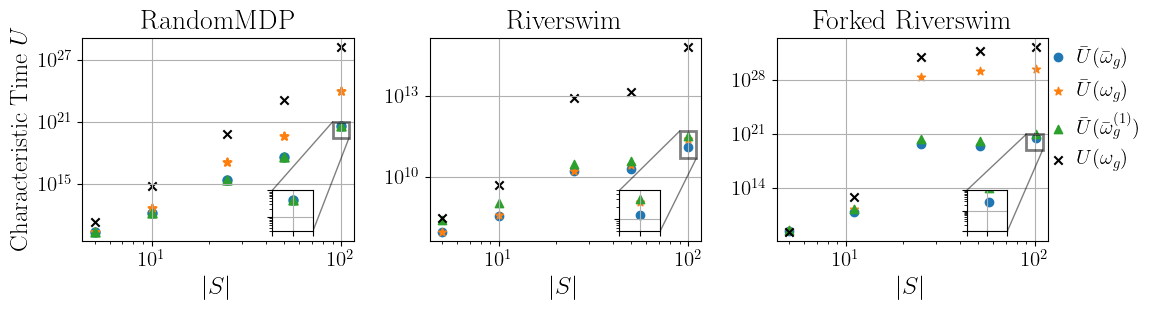

In [5]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))
fmts = ['o', '*', '^', 'x', '+']


#inset axes
axins = ax[0].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[0].transAxes)

mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0'])
ce = np.vstack([ce_low, ce_high])
ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[0], linewidth=1.5, )# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.scatter(data_random_mdp['Nvalues'], mu,  marker=fmts[0], linewidth=1.5, )# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0_original_omega'])
ce = np.vstack([ce_low, ce_high])
ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[1], linewidth=1.5, )# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.scatter(data_random_mdp['Nvalues'], mu, marker=fmts[1], linewidth=1.5, )# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0_simplified_omega'][..., 0])
ce = np.vstack([ce_low, ce_high])
ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[2], linewidth=1.5,)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.scatter(data_random_mdp['Nvalues'], mu, marker=fmts[2], linewidth=1.5,)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_original_bound'])
ce = np.vstack([ce_low, ce_high])
ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[3], linewidth=1.5, color='k',)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.scatter(data_random_mdp['Nvalues'], mu, marker=fmts[3], linewidth=1.5, color='k',)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')



ax[0].set_xlabel('$|S|$')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].grid()



axins.set_xlim(90, 110)
axins.set_ylim(3e19, 1e21)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[0].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)



ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_original_omega'],  marker=fmts[1],label='value original omega')
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'][..., 0], marker=fmts[2], label='value original omega')
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_original_bound'], marker=fmts[3], color='k',label='original')



ax[1].set_xlabel('$|S|$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].grid()

# inset axes
axins = ax[1].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[1].transAxes)
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'][..., 0], marker=fmts[2])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_original_bound'], marker=fmts[3], color='k')
axins.set_xlim(90, 110)
axins.set_ylim(5e10, 5e11)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[1].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)



xvalues_forked = np.array(data_forked_riverswim['Nvalues'])*2 -1

ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0], label=r'$\bar U(\bar \omega_{g})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1], label=r'$\bar U(\omega_{g})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'][..., 0], marker=fmts[2], label=r'$\bar U(\bar \omega_{g}^{(1)})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_original_bound'], marker=fmts[3], color='k',label=r'$U(\omega_{g})$')


ax[2].set_xlabel('$|S|$')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].grid()



# inset axes
axins = ax[2].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[2].transAxes)
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0])
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1])
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'][..., 0], marker=fmts[2])
axins.scatter(xvalues_forked, data_forked_riverswim['U_original_bound'], marker=fmts[3], color='k')
axins.set_xlim(90, 110)
axins.set_ylim(1e19, 1e21)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[2].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)


ax[0].set_ylabel('Characteristic Time $U$')
ax[0].set_title('RandomMDP')
ax[1].set_title('Riverswim')
ax[2].set_title('Forked Riverswim')

ax[2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
# plt.savefig('./figures/bound_characteristic_time_analysis.pdf')


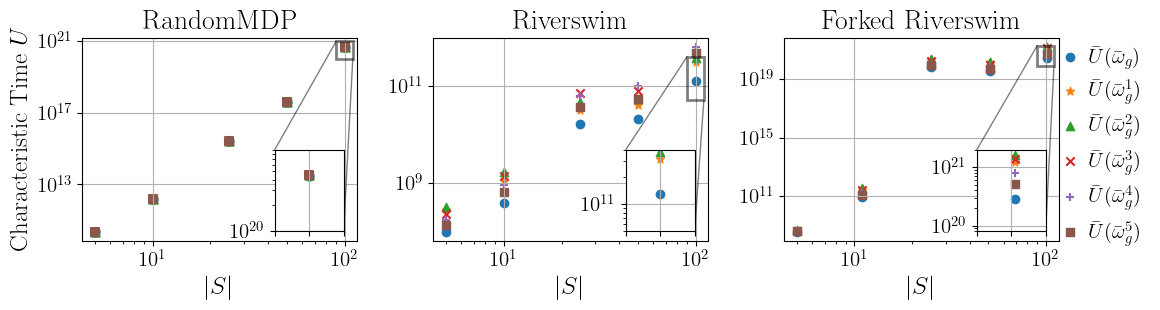

In [6]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))
fmts = ['o', '*', '^', 'x', '+', 's']

# inset axes
axins = ax[0].inset_axes([0.7, 0.05, 0.25, 0.4], transform=ax[0].transAxes)

mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0'])
ce = np.vstack([ce_low, ce_high])
ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[0], linewidth=1.5, )
axins.scatter(data_random_mdp['Nvalues'], mu, marker=fmts[0], linewidth=1.5, )

for i in range(5):
    mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0_simplified_omega'][..., i])
    ce = np.vstack([ce_low, ce_high])
    ax[0].scatter(data_random_mdp['Nvalues'], mu, marker=fmts[1 + i], linewidth=1.5,)
    axins.scatter(data_random_mdp['Nvalues'], mu, marker=fmts[1 + i], linewidth=1.5,)

ax[0].set_xlabel('$|S|$')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].grid()
axins.set_xlim(90, 110)
axins.set_ylim(1e20, 9e20)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([], minor=True)
ax[0].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)





axins = ax[1].inset_axes([0.7, 0.05, 0.25, 0.4], transform=ax[1].transAxes)
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
for i in range(5):
    ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'][..., i], marker=fmts[i+1], label='value original omega')
    axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'][..., i], marker=fmts[i+1])
ax[1].set_xlabel('$|S|$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].grid()
axins.set_xlim(90, 110)
axins.set_ylim(5e10,4e11)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([], minor=True)
ax[1].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)





xvalues_forked = np.array(data_forked_riverswim['Nvalues'])*2 -1
axins = ax[2].inset_axes([0.7, 0.05, 0.25, 0.4], transform=ax[2].transAxes)
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0], label=r'$\bar U(\bar \omega_{g})$')
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0])
for i in range(5):
    ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'][..., i], marker=fmts[i+1], label=f'$\\bar U(\\bar \\omega_{"{g}"}^{(i + 1)})$')
    axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'][..., i], marker=fmts[i+1])

ax[2].set_xlabel('$|S|$')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].grid()

axins.set_xlim(90, 110)
axins.set_ylim(8e19, 2e21)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([], minor=True)
ax[2].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)



ax[0].set_ylabel('Characteristic Time $U$')
ax[0].set_title('RandomMDP')
ax[1].set_title('Riverswim')
ax[2].set_title('Forked Riverswim')

ax[2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
#plt.savefig('./figures/bound_characteristic_time_analysis_full.pdf')


In [10]:
### Compute statistics
N=300
Nvalues = [5, 10, 25, 50, 100]

stats = {
    x: {
        'delta_min': np.zeros(N),
        'var_v': np.zeros((N, x, 3)),
        'span_v':np.zeros((N, x, 3)),
        'delta_sa':np.zeros((N, x, 3)),
        'Mkvalues':np.zeros((N, 19)),
    } for x in Nvalues
}
for i in tqdm(range(N)):
    for id_n, n_val in enumerate(Nvalues):
        env = RandomMDP(n_val)
        mdp = MDPDescription(env.transitions, env.rewards, discount_factor)
        stats[n_val]['delta_min'][i] = mdp.delta_sq_min ** 0.5
        stats[n_val]['var_v'][i] = mdp.var_V_greedy
        stats[n_val]['span_v'][i] = mdp.span_V_greedy
        stats[n_val]['delta_sa'][i] = mdp.delta_sq ** 0.5
        stats[n_val]['Mkvalues'][i] = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]

  2%|▏         | 7/300 [00:26<18:17,  3.75s/it]

In [ ]:
print('RandomMDP')
print(f'Delta_min: {CE(delta_min)}')
print(f'delta max: {CE(delta_sa.reshape(N,-1).max(-1))}')
print(f'span max: {CE(span_v.reshape(N,-1).max(-1))}')
print(f'span min: {CE(span_v.reshape(N,-1).min(-1))}')
print(f'Var max: {CE(var_v.reshape(N,-1).max(-1))}')
print(f'Var min: {CE(var_v.reshape(N,-1).min(-1))}')

barkmax = CE(Mkvalues.argmax(1) + 1)[0]
barkmin = CE(Mkvalues.argmin(1) + 1)[0]
print(f'Max Mk: {CE(Mkvalues.max(1) ** (2 ** barkmax))} - kbar: {CE(Mkvalues.argmax(1) + 1)}')
print(f'Max Mk: {CE(Mkvalues.min(1) ** (2 ** barkmin))} - kbar: {CE(Mkvalues.argmin(1) + 1)}')

RandomMDP
Delta_min: (0.00027498970910280935, 2.893024167897454e-05)
delta max: (0.016269417006134088, 0.0003145529901058214)
span max: (0.008633503278098698, 0.00025454952518256033)
span min: (0.007491844288601263, 0.00022831851052806845)
Var max: (1.544918508822472e-05, 8.547516172374236e-07)
Var min: (9.455848888630195e-06, 4.989002698779461e-07)
Max Mk: (3.602786154737034e-67, 7.089748725177306e-67) - kbar: (19.0, 0.0)
Max Mk: (1.5449185087659545e-05, 8.547516171960298e-07) - kbar: (1.0, 0.0)


In [ ]:
print('RiverSwim')
Nvalues = [5, 10, 25, 50, 100]

stats_riverswim = {
    x: {
        'delta_min': 0,
        'var_v': np.zeros((x, 3)),
        'span_v':np.zeros((x, 3)),
        'delta_sa':np.zeros((x, 3)),
        'Mkvalues':np.zeros((19)),
    } for x in Nvalues
}

for id_n, n_val in enumerate(Nvalues):
    env = RiverSwim(num_states=n_val)
    mdp = MDPDescription(env.transitions, env.rewards, discount_factor)
    stats_riverswim[n_val]['delta_min'] = mdp.delta_sq_min ** 0.5
    stats_riverswim[n_val]['var_v'] = mdp.var_V_greedy
    stats_riverswim[n_val]['span_v'] = mdp.span_V_greedy
    stats_riverswim[n_val]['delta_sa'] = mdp.delta_sq ** 0.5
    stats_riverswim[n_val]['Mkvalues'] = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]



RiverSwim
Delta_min: 0.04608849870719922
delta max: 1.3279392942230217
span max: 13.871981037315043
span min: 7.151606310099515
Var max: 0.4253940018542721
Var min: 0.0
Max Mk: 1.010621240900785 - kbar: 6


In [ ]:
print(f'Delta_min: {mdp.delta_sq_min ** 0.5}')
print(f'delta max: {(mdp.delta_sq ** 0.5).max()}')
print(f'span max: {mdp.span_V_greedy.max()}')
print(f'span min: {mdp.span_V_greedy.min()}')
print(f'Var max: {mdp.var_V_greedy.max()}')
print(f'Var min: {mdp.var_V_greedy.min()}')
valK = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]
print(f'Max Mk: {np.max(valK)} - kbar: {np.argmax(valK) + 1}')


In [ ]:
print('Forked RiverSwim')

Nvalues = [3, 6, 13, 26, 51]

stats_forked_riverswim = {
    x: {
        'delta_min': 0,
        'var_v': np.zeros((x, 3)),
        'span_v':np.zeros((x, 3)),
        'delta_sa':np.zeros((x, 3)),
        'Mkvalues':np.zeros((19)),
    } for x in Nvalues
}

for id_n, n_val in enumerate(Nvalues):
    env = ForkedRiverSwim(river_length=n_val)
    mdp = MDPDescription(env.transitions, env.rewards, discount_factor)
    stats_forked_riverswim[n_val]['delta_min'] = mdp.delta_sq_min ** 0.5
    stats_forked_riverswim[n_val]['var_v'] = mdp.var_V_greedy
    stats_forked_riverswim[n_val]['span_v'] = mdp.span_V_greedy
    stats_forked_riverswim[n_val]['delta_sa'] = mdp.delta_sq ** 0.5
    stats_forked_riverswim[n_val]['Mkvalues'] = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]




Forked RiverSwim
Delta_min: 6.480097347605351e-07
delta max: 1.3271947955331527
span max: 3.6719968802414193
span min: 1.9111871786871184
Var max: 0.7192516731564638
Var min: 0.0
Max Mk: 1.5037713542093074 - kbar: 2


In [ ]:

print(f'Delta_min: {mdp.delta_sq_min ** 0.5}')
print(f'delta max: {(mdp.delta_sq ** 0.5).max()}')
print(f'span max: {mdp.span_V_greedy.max()}')
print(f'span min: {mdp.span_V_greedy.min()}')
print(f'Var max: {mdp.var_V_greedy.max()}')
print(f'Var min: {mdp.var_V_greedy.min()}')
valK = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]
print(f'Max Mk: {np.max(valK)} - kbar: {np.argmax(valK)}')

In [ ]:
discount_factor = 0.99

kvalues = range(1, 20)
num_states = [5, 10, 25, 50, 100]

values_riverswim = {N: [] for N in num_states}
values_forked_riverswim = {N: [] for N in num_states}
values_random_mdp = {N: [] for N in num_states}

    
def computeMK(mdp,k):
    P = mdp.P.reshape(mdp.dim_state * mdp.dim_action, -1)
    temp = (mdp.V_greedy[:, np.newaxis, np.newaxis] - mdp.avg_V_greedy[np.newaxis, ...]) ** (2*k)
    Mk = (P * temp.reshape(mdp.dim_state, mdp.dim_state * mdp.dim_action).T).sum(-1).reshape(mdp.dim_state, mdp.dim_action)
    return Mk

for N in num_states:
    env_rv = RiverSwim(num_states=N)
    env_frv = ForkedRiverSwim(river_length=N)

    mdp_rv = MDPDescription(env_rv.transitions, env_rv.rewards, discount_factor)
    mdp_frv = MDPDescription(env_frv.transitions, env_frv.rewards, discount_factor)
    for k in kvalues:
        mk_rv = computeMK(mdp_rv,k)
        mk_frv = computeMK(mdp_frv,k)
        values_riverswim[N].append(mk_rv.max() ** (2 ** (-k)))
        values_forked_riverswim[N].append(mk_frv.max() ** (2 ** (-k)))
        
    _rand_values = np.zeros((30,len(kvalues)))
    for j in range(_rand_values.shape[0]):
        env = RandomMDP(N)
        mdp_random = MDPDescription(env.transitions, env.rewards, discount_factor)
        for idk, k in enumerate(kvalues):
            mk_random = computeMK(mdp_random, k)
            _rand_values[j,idk] = (mk_random.max()  ** (2 ** (-k)))
    values_random_mdp[N] = _rand_values
        
    

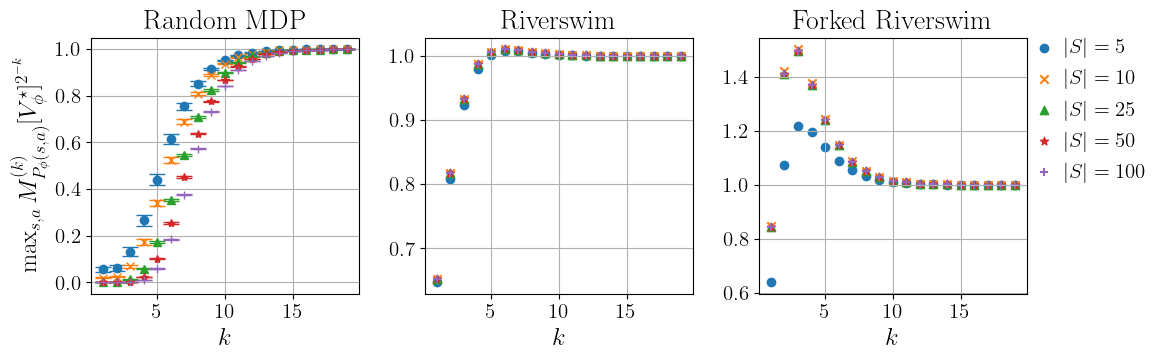

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

fmts = ['o', 'x', '^', '*', '+']
for axid, N in enumerate(num_states):
    mu, ce = CE(values_random_mdp[N])
    ce = np.vstack([ce, ce])
    
    ax[0].errorbar(kvalues, mu, ce, fmt=fmts[axid], linewidth=1.5, capsize=6,  label=f'$|S|={N}$')


    ax[1].scatter(kvalues, values_riverswim[N],marker=fmts[axid], label=f'$|S|={N}$')
    ax[2].scatter(kvalues, values_forked_riverswim[N],marker=fmts[axid], label=f'$|S|={N}$')

for i in range(3):
    ax[i].set_xlabel('$k$')
    #ax[i].set_yscale('log')
    ax[i].grid()
ax[2].legend(bbox_to_anchor=(1.45, 1), borderaxespad=0., frameon=False,borderpad=0.,labelspacing=0.5, handletextpad=0.)
ax[0].set_title('Random MDP')
ax[1].set_title('Riverswim')
ax[2].set_title('Forked Riverswim')
ax[0].set_ylabel(r'$\max_{s,a}M_{P_\phi(s,a)}^{(k)}[V_\phi^\star]^{2^{-k}}$')
plt.tight_layout()
plt.savefig('figures/evaluation_k.pdf')